### MNIST Hand-Written Digit Recognition

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. (Wikipedia) 


After completing this tutorial you will be able to implement and train a neural network with two hidden layers, that can recognize digit of an image with accuracy more than 90%.

#### Data and Helper Functions
First we need to import the libraries we will be using.

In [1]:
import numpy as np                     # numpy is a standard library for numerical 
                                       # computations
np.random.seed(0)
    
import tensorflow as tf                # deep learning library, in this tutorial 
                                       # we will use it only to download the data
import matplotlib.pyplot as plt        # matplotlib.pyplot is a plotting library 

Second we need to load the data. It consist of the images and labels. Each image is 28 by 28 pixels and is stored as a flattened `np.array` of length 784 (28 * 28). Each label is a single number from 0 to 9. The data is split into train and test set, which are used for training and evaluating the network respectively. 

In [2]:
# This might throw some warnings 
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images 
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images 
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Let's have a look how one image (and it's corresponding label) might look like. 

Label for this image is  7


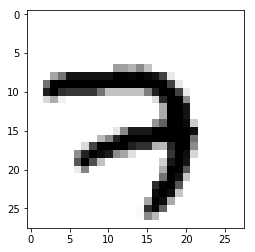

In [3]:
print("Label for this image is ", train_labels[0])
plt.imshow(-train_data[0].reshape((28,28)), cmap="gray")
plt.show()

We will use the following two helper functions and their derivatives. For further detail please refer to: 

- https://en.wikipedia.org/wiki/Sigmoid_function

- https://en.wikipedia.org/wiki/Softmax_function

In [4]:
def sigmoid(z, derivative = False): 
    """ Sigmoid function (resp. its derivative) of z
    
    Args: 
    z -- A np.array (k x 1)
    
    Returns: 
    #TODO
    """
    sig = 1/(1+np.exp(-z))
    if not derivative:
        return sig
    else: 
        return np.diag((sig * (1-sig)).T[0])

In [5]:
def softmax(z, derivative = False): 
    """ Softmax function (resp. its derivative) of z
    
    Args: 
    z -- A np.array (k x 1)
    
    Returns: 
    # TODO
    """
    e = np.exp(z)
    e = e / np.sum(e, axis = 0)
    if not derivative:
        return e
    else:
        D_shape = (len(e),)*2
        D = np.zeros(D_shape)
        for i in range(len(e)): 
            for j in range(len(e)):
                D[i,j] = e[i]*((i==j)*1-e[j])
        return D

#### The Architecture of the NN

Now we define the architecture of the neural network. In our case the network will have 
- one input layer with 784 (28 * 28) neurons. Each neuron will represent one pixel of the input image. 
- Two hidden layers with 64 and 32 neurons and a sigmoid activation function. 
- An output layer with 10 neurons and softmax activation function. The `i`-th element of the output vector will correspond to the probability that the input image contains digit `i`. 

This is a fancy way of saying what can be summarized by this equation: 

$$ \hat{y} = softmax\bigg ( W_{2} \sigma \big ( W_{1} \sigma ( W_{0} x + b_{0}) + b_{1} \big ) + b_{2} \bigg ) $$

where 
- $\hat{y}$ is a (10 x 1) vector of output probabilities 
- $x$ is a (784 x 1) vector representing pixel values of the input image


- $softmax$ is the softmax function 
- $\sigma$ is the sigmoid function


- $W_{2}$ is a (10 x 32) matrix, $b_{2}$ is a (10 x 1) vector
- $W_{1}$ is a (32 x 64) matrix, $b_{1}$ is a (32 x 1) vector
- $W_{0}$ is a (64 x 784) matrix, $b_{0}$ is a (784 x 1) vector

Note that each layer has the general form of 
$$l(z) = f(Wz + b) $$
and the whole neural network consists of just a few layers stacked over each other. The function $f$ is called an activation function, the input vector $z$ (which is often output of the previous layer or the input to the whole nn) is called an input of the layer and the value $f(Wz + b)$ is called the output of the layer. 

In [6]:
layer_in_size = 28 ** 2
layer_1_size = 64
layer_2_size = 32
layer_out_size = 10

We do not yet know what values should the matrices and vectors $W_{i}, b_{i}, i = 0, \dots, 2$ have, so for now, we initialize them randomly. It is important not to pick the random numbers either too large or too small. Do not worry about this now. 

In [7]:
W_0 = np.random.randn(layer_1_size, layer_in_size) / np.sqrt(layer_in_size) ## the np.sqrt() term is there 
b_0 = np.random.randn(layer_1_size, 1)                                      ## so that each entry of the output 
                                                                            ## vector has variance +/- 1 
W_1 = np.random.randn(layer_2_size, layer_1_size) / np.sqrt(layer_1_size)
b_1 = np.random.randn(layer_2_size, 1)

W_2 = np.random.randn(layer_out_size, layer_2_size) / np.sqrt(layer_2_size)
b_2 = np.random.randn(layer_out_size, 1)

Finally we write in python the function (our neural network), that calculates the output probabilities from input image $x$ and $W$'s and $b$'s.

In [8]:
def forward_pass(x, W_0, W_1, W_2, b_0, b_1, b_2): 
    """
    Forward pass of the neural network 
    
    Args: 
    x -- A `np.array` of shape (784,1), 
        represents the input image. 
    W_0, W_1, W_2, b_0, b_1, b_2 -- A `np.arrays` 
        of shapes 
        (64, 784), 
        (32, 64), 
        (10, 32), 
        (64, 1), 
        (32, 1), 
        (10, 1) respectively. 
        These represent the trainable 
        parameters of the neural network.
        
    Returns:
    a_2, z_2, a_1, z_1, a_0, z_0 -- A `np.arrays` 
        of shapes 
        # TODO
        These represent the outputs (#TODO -- terminology for z)
        /activations of the nn's layers. 
    """
    z_0 = W_0 @ x + b_0
    a_0 = sigmoid(z_0)
    
    z_1 = W_1 @ a_0 + b_1
    a_1 = sigmoid(z_1)
    
    z_2 = W_2 @ a_1 + b_2
    a_2 = softmax(z_2)
    
    return a_2, z_2, a_1, z_1, a_0, z_0

Having defined our neural network we need to evaluate how well it actually recognizes the images. For the purpose of this, we could use for example the percentage of correctly identified images from the test set. 

In [9]:
def calculate_accuracy(W_0, W_1, W_2, b_0, b_1, b_2, eval_data, eval_labels): 
    """ Calculates the percentage of correctly identified images on eval_data, eval_labels
    """
    predicted_digits = np.argmax(W_2 @ sigmoid(W_1 @ sigmoid(W_0 @ eval_data.T + b_0) + b_1) + b_2, axis = 0)
    acc = np.mean(predicted_digits == eval_labels)
    return acc

In [10]:
acc = calculate_accuracy(W_0, W_1, W_2, b_0, b_1, b_2, eval_data, eval_labels)
print("Accuracy on the test set is ", acc * 100, "%")

Accuracy on the test set is  9.8 %


As we can see, the network has about 10% accuracy on the test set. This is as good as random guess, which is no wonder since we initilized the parameters $W, b$ randomly. 

Luckily, we can do something about that. First let's ditch the accuracy function we defined above and use another function called cross entropy. Having a prediction $\hat{y}$ and true label $y$ the cross entropy is defined as $$- y * \log{\hat{y}}$$ where $y$ is a vector with 9 zeros and 1 one, which location corresponds to the label digit.  

The reason for this change is that the cross entropy is much more precise measure of how good the nn predicts the outputs. Be careful that SMALLER cross entropy means bette predictions. # TODO - explain why

In [11]:
def loss(y_hat, y): 
    """ Cross Entropy 
    Args: 
    y -- A `np.array` of shape (10, 1) with 9 zeros 
        and 1 one. Represents the true label.  
    y_hat -- A `np.array` of shape (10, 1) containing 
        probabilities, sums up to one. 
        
    Returns: 
    cross_entropy -- # TODO
    """
    cross_entropy = -np.sum(y * np.log(y_hat), axis=0)
    return cross_entropy

Now we have a function (the cross entropy) that measures how good (resp. bad) is a particular choice of $W, b$ in recognizing the digits on images, we can fiddle with the values of $W, b$ and try to maximize (resp. minimize) this function (which is btw. called the loss function in the case of minimization) to achieve the best results in this task. 

To sumarize, we will now try to minimize 

 $J(x, y, W_0, W_1, W_2, b_0, b_1, b_2) = - y * \log \bigg \lbrace softmax\bigg ( W_{2} \sigma \big ( W_{1} \sigma ( W_{0} x + b_{0}) + b_{1} \big ) + b_{2} \bigg ) \bigg \rbrace $
 
with respect to $W_0, W_1, W_2, b_0, b_1, b_2$ across all observations $x, y$, where x = input image, y = output label. To do this we we will use a method called stochastic gradient descent. For this, we will need to calculate gradients of $J$ with respect to $W$'s and $b$'s. 


This is definitely the hardest part and probably a good time to refresh some matrix calculus. 

One non-standard rule useful for derivation of the gradients is: 
$$ \frac{\partial}{\partial W} y^{\top} f (W z) = (y^{\top} \nabla f(W z))^{\top} z^{\top} $$

In [12]:
def backward_pass(x, y, \
                  a_2, z_2, a_1, z_1, a_0, z_0, \
                  W_0, W_1, W_2, b_0, b_1, b_2):
    """
    Calculates gradients of J w.r.t. W_0, W_1, W_2, b_0, b_1, b_2
    
    Args: 
    x -- A `np.array` of shape (784,1), 
        represents the input image. 
    y -- A `np.array` of shape (10, 1) with 9 zeros 
        and 1 one. Represents the true label. 
    a_2, z_2, a_1, z_1, a_0, z_0 -- A `np.array`s 
        the output of forward pass. 
    W_0, W_1, W_2, b_0, b_1, b_2 -- A `np.array`s 
        the parameters of the nn. 
        
    Returns: 
    dW_0, dW_1, dW_2, db_0.T, db_1.T, db_2.T -- A `np.array`s, 
        the gradients of J w.r.t. Ws and bs
    """
    db_2 = - y.T @ np.diag(1/a_2.T[0]) @ softmax(z_2, derivative=True)
    dW_2 = db_2.T @ a_1.T
    
    db_1 = db_2 @ W_2 @ sigmoid(z_1, derivative=True) 
    dW_1 = db_1.T @ a_0.T
    
    db_0 = db_1 @ W_1 @ sigmoid(z_0, derivative=True)
    dW_0 = db_0.T @ x.T
    
    return dW_0, dW_1, dW_2, db_0.T, db_1.T, db_2.T

Finally we can train the network. At each step we do 
- the forward pass and calculate the activations 
- we use the activations to calculate the gradients 
- we update the parameters of the nn using the obtained gradients 



In [13]:
train_steps = 1000      # How many times to repeat the gradient descent 
batch_size = 32         # How many x-y observations to use for the gradient calculation in one step 
learning_rate = 1.0     # How much to update the parameters using the calculated gradients 

for i in range(train_steps): 
    # Check out the original accuracy from time to time
    accuracy = calculate_accuracy(W_0, W_1, W_2, b_0, b_1, b_2, eval_data, eval_labels)
    if i % 100 == 0:
        print("Accuracy in iteration ", i, "is", accuracy)
    
    # Select the x,y observations for the gradient calculation
    batch_indices = np.random.choice(train_data.shape[0], batch_size)
    x_batch = train_data[batch_indices]
    y_batch = np.zeros((batch_size, layer_out_size)) 
    y_batch[range(batch_size), train_labels[batch_indices]] = 1

    # Initilize the gradients 
    grad = [np.zeros_like(t) for t in [W_0, W_1, W_2, b_0, b_1, b_2]]

    # Calculate the gradient for each (x,y) pair separately and add to the 
    # total gradient 
    for j in range(batch_size): 
        x = x_batch[j].reshape(-1,1)
        y = y_batch[j].reshape(-1,1)
        a_2, z_2, a_1, z_1, a_0, z_0 = forward_pass(x, W_0, W_1, W_2, b_0, b_1, b_2)
        dt = backward_pass(x, y, \
                      a_2, z_2, a_1, z_1, a_0, z_0, \
                      W_0, W_1, W_2, b_0, b_1, b_2)
        grad = [g + g_inc for g,g_inc in zip(grad, dt)]

    # Divide the sum of gradients by the number of observations 
    grad = [g / batch_size for g in grad]
    dW_0, dW_1, dW_2, db_0, db_1, db_2 = grad

    # Update the parameters 
    W_0 = W_0 - learning_rate * dW_0
    W_1 = W_1 - learning_rate * dW_1
    W_2 = W_2 - learning_rate * dW_2
    b_0 = b_0 - learning_rate * db_0
    b_1 = b_1 - learning_rate * db_1
    b_2 = b_2 - learning_rate * db_2
    
print("Training done. ")

Accuracy in iteration  0 is 0.098
Accuracy in iteration  100 is 0.6595
Accuracy in iteration  200 is 0.8317
Accuracy in iteration  300 is 0.8388
Accuracy in iteration  400 is 0.8964
Accuracy in iteration  500 is 0.9004
Accuracy in iteration  600 is 0.9073
Accuracy in iteration  700 is 0.915
Accuracy in iteration  800 is 0.9178
Accuracy in iteration  900 is 0.9188


Now let's see how the network does on some evaluation data. 

The predicted number is:  5


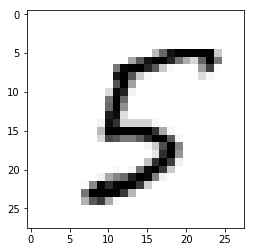

In [17]:
image_number = 23 # Number between 0 and 10 000 

x = eval_data[image_number]
y = np.argmax(forward_pass(x.reshape(784, 1), W_0, W_1, W_2, b_0, b_1, b_2)[0])
print("The predicted number is: ", y)
plt.imshow(-x.reshape((28,28)), cmap="gray")
plt.show()